# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. This notebook allowed me to apply statistical concepts such as hypothesis testing and statistical techniques such as bootstrapping using Python. This was part of my Udacity Data Analyst Nanodegree

For this project, we work to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# read in the data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# number of rows in dataset
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
# number of unique users
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
# proportion of users converted
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# count 1st combination mixup
mixup1 = df.query('group == "treatment" & landing_page == "old_page"').count()

In [7]:
# count 2nd combination mixup
mixup2 = df.query('group == "control" & landing_page == "new_page"').count()

In [8]:
# times where new_page and treatment don't line up
total_mixup = mixup1 + mixup2
total_mixup

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [9]:
# there are no missing values
df.isnull().sum().sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Create a new dataset removing the inaccurate data.  Store your new dataframe in **df2**.

In [10]:
# create new dataset removing inaccurate data
df2 = df.query('group == "control" & landing_page == "old_page" | group == "treatment" & landing_page == "new_page"')

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [12]:
# count of uniquie user_ids
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# create user_duplicate column, use duplicated function to tag it
df2["user_duplicate"] = df2.duplicated('user_id')

C:\Users\wilbertk\AppData\Local\Continuum\miniconda3\envs\python-analysis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


c. What is the row information for the repeat **user_id**? 

In [14]:
# filter for duplicates, show row information
df2.query('user_duplicate == True')

,user_id,timestamp,group,landing_page,converted,user_duplicate
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


In [15]:
#show entries with same user id
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted,user_duplicate
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
# drop duplicate, based on user_id
df2.drop_duplicates('user_id', inplace=True)

C:\Users\wilbertk\AppData\Local\Continuum\miniconda3\envs\python-analysis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
#confirm duplicate dropped
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted,user_duplicate
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False


`4.`

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
# probability of individual converting regardless of page
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
# probability of individual converting, if control
control_df = df2.query('group == "control"')
control_df.converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
# probability of individual converting, if treatment
treat_df = df2.query('group == "treatment"')
treat_df.converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
# probability individual received new page
new_df = treat_df.count() / df2.count()
print(new_df)

user_id           0.500062
timestamp         0.500062
group             0.500062
landing_page      0.500062
converted         0.500062
user_duplicate    0.500062
dtype: float64


e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**Given the probabilities (both the control and the treatment group have similar conversion rates to the whole dataset and the probability that an individual received the new page), it does not appear that one page leads to more conversions than the other.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} = p_{old} \\
H_1: p_{new} \ne p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
# show convert rate for p-new
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null?

In [23]:
# show convert rate for p-old
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [24]:
# number of entries with new_page
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [25]:
# number of entries with old_page
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
# simulate new_page_converted
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new], replace=True)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
# simulate old_page_converted
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old], replace=True)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
# calculate difference of p-new and p-old
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.0014611829211585714

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [29]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new], replace=True)
    old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old], replace=True)
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [30]:
# convert to array
p_diffs = np.array(p_diffs)

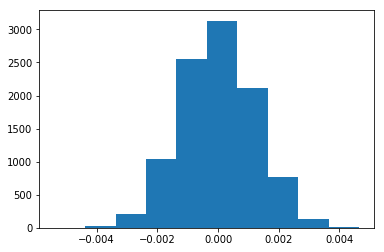

In [31]:
# plot p_diffs
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
# calculate null values
null_vals = np.random.normal(0, p_diffs.std(),p_diffs.size)

In [33]:
obs_diff = (treat_df.converted.mean() - control_df.converted.mean())

In [34]:
# calculate p-value
p_value = (null_vals > obs_diff).mean()
p_value

0.9022

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In part J, I calculated the p-value. The definition of a p-value is "the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true."**

**In this case, the p_value (.90) is greater than our reasonable type I error rate (.05). As a result, this shows that there is no difference in the average conversion between new and old pages (we fail to reject the null hypothesis).**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
# calculate z-score, p-value using built-in
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value
# p-value: 0.90505831275902449, z-score: 1.3109241984234394

(1.3109241984234394, 0.9050583127590245)

In [37]:
from scipy.stats import norm

norm.cdf(z_score)

0.9050583127590245

In [38]:
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p-value calculated using the built-in was similar to the one I calculated in part J. It is also larger than the reasonable type 1 error (0.05), so we fail to reject the null hypothesis.**

**The z-score shows the number of standard deviations from the mean. In this case, the z-score is 1.31. For a 95% confidence interval, our z-score would need to be greater than 1.96 in order for us reject the null hypothesis.**

**So both measures confirm that we fail to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since there are only two possible outcomes, a logistic regression will work best in this case.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
df2['intercept'] = 1

C:\Users\wilbertk\AppData\Local\Continuum\miniconda3\envs\python-analysis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
df2['ab_page'] = pd.get_dummies(df2['landing_page'])['new_page']

C:\Users\wilbertk\AppData\Local\Continuum\miniconda3\envs\python-analysis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [41]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 23 Mar 2019   Pseudo R-squ.:               8.077e-06
Time:                        16:02:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  

**The p-value associated with ab_page is 0.190.**

**In part II, we assumed that p-new <= p-old (null hypothesis), and therefore our alternative was that p-new > p-old. The p-value of 0.9 from part ii is the result for a one-tailed hypothesis test.**

**In the logistic regression model, the null hypothesis is that p_new equals p_old. Therefore the alternative hypothesis is that p_new is not equal to p_old. Its p-value result of 0.19 is the result for a two-tailed hypothesis test.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**By considering other factors, the model may fit better or provide more accurate predictions. On the other hand, the interpretation may get more complex, especially if the explanatory variables interact with each other in addition to the response variables. Then, we would need to figure out those interactions and add other variables to mitigate them.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns -  Provide the statistical output as well as a written response to answer this question.

In [43]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
df2 = df2.set_index('user_id').join(countries.set_index('user_id'))

In [45]:
df2.head()

,timestamp,group,landing_page,converted,user_duplicate,intercept,ab_page,country
user_id,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0,US


In [46]:
# discern dummy variable columns and  baseline
df2.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [47]:
# create dummy columns for countries
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])


In [48]:
# confirm dummy columns
df2.head()

,timestamp,group,landing_page,converted,user_duplicate,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0,US,0,0,1


In [49]:
# run logistic regression for converted by page on conversion and country
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page', 'US', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 23 Mar 2019   Pseudo R-squ.:               2.323e-05
Time:                        16:02:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

**Does it appear that country had an impact on conversion?**

**No, it does not appear that country have an impact. The p-values are larger than .05, so that would lead me to believe that they did not have a significant effect on conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [50]:
# create columns for interactions
df2['page_US'] = df2['ab_page']*df2['US']
df2['page_UK'] = df2['ab_page']*df2['UK']

In [51]:
# run logistic regression for converted by page on conversion and country, with interactions for each country
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page', 'page_US', 'page_UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 23 Mar 2019   Pseudo R-squ.:               3.351e-05
Time:                        16:02:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0827      0.038     -2.176      0.030      -0.157      -0.008
page_US        0.0644      0.038      1.679      0.093      -0.011       0.140
page_UK        0.0901      0.040      2.225      0.026       0.011       0.169
==============================================================================
"""

In [52]:
1/np.exp(-.0827)

1.086215894895166

In [53]:
np.exp(0.0644), np.exp(0.0901)

(1.0665189210197745, 1.0942837066046347)

**In this summary, it appears that both ab_page and page_UK have p-values less than .05. This suggests that they do have a significant effect on conversion.**

